# Imports

In [1]:
import pandas as pd
import numpy as np
import json
from random import randrange
import matplotlib.pyplot as plt

from langchain_ollama import ChatOllama
from langchain.schema import HumanMessage, SystemMessage


# Load Data

In [2]:
df_init = pd.read_parquet('../data/train_2wiki.parquet')

# Quick Pre-Processing
df_init.drop(columns = ['_id', 'type', 'evidences'], axis = 1, inplace=True)
df_init.supporting_facts = df_init.supporting_facts.apply(lambda x: eval(x))
df_init['size_gt'] = df_init.supporting_facts.apply(lambda x: len(x))
df_init['size_gt_doc'] = df_init.supporting_facts.apply(lambda x: len(list(np.unique([elem[0] for elem in x]))))

df_init.head()

,question,context,supporting_facts,answer,size_gt,size_gt_doc
0,Are director of film Move (1970 Film) and dire...,"[[""Stuart Rosenberg"", [""Stuart Rosenberg (Augu...","[[Move (1970 film), 0], [Méditerranée (1963 fi...",no,4,4
1,Do both films The Falcon (Film) and Valentin T...,"[[""The Falcon Takes Over"", [""The Falcon Takes ...","[[The Falcon (film), 0], [Valentin the Good, 0...",no,5,4
2,"Which film whose director is younger, Charge I...","[[""Danger: Diabolik"", [""Danger:"", ""Diabolik i...","[[Charge It to Me, 1], [Danger: Diabolik, 1], ...",Danger: Diabolik,4,4
3,What is the date of birth of Mina Gerhardsen's...,"[[""Pamela Jain"", [""Pamela Jain is an Indian pl...","[[Mina Gerhardsen, 1], [Rune Gerhardsen, 0]]",13 June 1946,2,2
4,What nationality is the director of film Weddi...,"[[""Weekend in Paradise (1931 film)"", [""Weekend...","[[Wedding Night in Paradise (1950 film), 0], [...",Hungarian,2,2


# Data Preparation

In [75]:
df_init_sentence = df_init[df_init.size_gt == 4].iloc[:500] # 500 samples
df_init_doc = df_init[df_init.size_gt_doc == 2].iloc[:200] # 200 samples

df_init_doc.reset_index(drop = True, inplace=True)
df_init_sentence.reset_index(drop=True, inplace=True)

## Select Queries

In [76]:
SYSTEM_PROMPT = (
    "You are a strict question-answering assistant. "
    "Answer the user's question directly. "
    "If you do not know the answer, respond only with: 'I am unable to answer this question.' "
    "Do not ask for clarification. Do not try to continue the conversation."
)

llm = ChatOllama(
    model="llama3.1:8b-instruct-q8_0",   # Make sure you've pulled it: `ollama pull llama-3.1-8b`
    temperature=0.0,        # deterministic answers
)

df = df_init_doc.copy()

def ask(question: str):
    response = llm.invoke([SystemMessage(content=SYSTEM_PROMPT),
                           HumanMessage(content=question)])
    print("Q:", question)
    print("A:", response.content)
    return response


store_responses = {k:"" for k in df.loc[:500].index}
for i in df.loc[:500].index:
    if i%100 == 0: 
        print(i)
    question = df.question.loc[i]
    store_responses[i] = ask(question)
store_responses = {k:v.content for k,v in store_responses.items()}

0
Q: What is the date of birth of Mina Gerhardsen's father?
A: I am unable to answer this question.
Q: What nationality is the director of film Wedding Night In Paradise (1950 Film)?
A: I am unable to answer this question.
Q: When is the composer of film Sruthilayalu 's birthday?
A: I am unable to answer this question.
Q: Who is Rhescuporis I (Odrysian)'s paternal grandfather?
A: Seuthes II.
Q: Which film came out first, The Love Route or Engal Aasan?
A: The Love Route was released in 1954 and Engal Aasan was released in 1962. Therefore, The Love Route came out first.
Q: Where was the director of film The Fascist born?
A: I am unable to answer this question.
Q: Are Matraville Sports High School and Wabash High School both located in the same country?
A: Yes, they are both located in Australia.
Q: Are Alison Skipper and Diane Gilliam Fisher from the same country?
A: Yes, Alison Skipper and Diane Gilliam Fisher are both from the United States.
Q: Do the movies Bloody Birthday and The Bec

In [79]:
with open("../data/select_queries_document_lvl_answers.json", 'w') as f: 
    json.dump(store_responses, f, indent=4)

In [112]:
df = pd.DataFrame.from_dict(store_responses_sentences, orient='index', columns = ['provided_answer'])
df[['question', 'answer']] = df_init_sentence[['question', 'answer']].loc[:430].copy()

### Evaluate LLM's Awareness

In [113]:
system_prompt = """
You are an impartial evaluator that assesses the correctness of answers given by another LLM.

You will be provided with:
- The question asked.
- The ground truth answer (the correct expected answer, or "no answer available" if none exists).
- The answer generated by the LLM.

Your task is to evaluate the LLM’s answer according to the following rules:

1. **Correctness**
   - If the LLM’s answer matches the ground truth answer semantically (even if wording differs), mark it as CORRECT.
   - If the LLM’s answer contradicts the ground truth or provides incorrect facts, mark it as INCORRECT.
   - If the LLM refuses to answer (“I am unable to answer this question.” or similar) and the ground truth has a valid answer, mark it as INCORRECT.
   - If the ground truth indicates *no answer is available*, and the LLM also refuses to answer, mark it as UNDEFINED.

2. **Completeness**
   - If the ground truth answer contains multiple pieces of information and the LLM answer only partially includes them, mark it as PARTIALLY_CORRECT.
   - If the LLM adds extra, fabricated, or misleading details beyond the ground truth, mark it as INCORRECT.

3. **Conciseness & Relevance**
   - Ignore verbosity or stylistic differences. Do not penalize if the LLM provides extra harmless context, as long as the factual content is correct.
   - Penalize if the extra context includes hallucinated or wrong facts.

4. **Final Output Format**
   Always respond with a JSON object containing the evaluation:
   {
     "correctness": "CORRECT | PARTIALLY_CORRECT | INCORRECT | UNDEFINED",
     "explanation": "A short explanation of why the answer was evaluated this way."
   }

---

### Example 1:
Question: Are director of film Move (1970 Film) and director of film Méditerranée (1963 Film) from the same country?  
Ground Truth Answer: "Move (1970) was directed by Stuart Rosenberg (USA). Méditerranée (1963) was directed by Jean-Daniel Pollet (France). They are from different countries."  
LLM Answer: "The 1970 film 'Move' was directed by Steven Spielberg, and 'Méditerranée' was directed by Jean-Daniel Pollet... No, they are not from the same country."  

Evaluation:  
{
  "correctness": "INCORRECT",
  "explanation": "The LLM incorrectly attributed 'Move (1970)' to Steven Spielberg instead of Stuart Rosenberg, even though it got the 'different countries' part right."
}

---

### Example 2:
Question: Are director of film Move (1970 Film) and director of film Méditerranée (1963 Film) from the same country?  
Ground Truth Answer: "Move (1970) was directed by Stuart Rosenberg (USA). Méditerranée (1963) was directed by Jean-Daniel Pollet (France). They are from different countries."  
LLM Answer: "I am unable to answer this question."  

Evaluation:  
{
  "correctness": "INCORRECT",
  "explanation": "The ground truth provides a clear answer, but the LLM refused to answer."
}

---

### Example 3:
Question: Who invented the perpetual motion machine?  
Ground Truth Answer: "No answer available (the perpetual motion machine does not exist)."  
LLM Answer: "I am unable to answer this question."  

Evaluation:  
{
  "correctness": "UNDEFINED",
  "explanation": "There is no valid ground truth answer, and the LLM correctly refused to provide one."
}"""

In [114]:
from google.oauth2 import service_account
import vertexai
from vertexai.generative_models import GenerativeModel
 
vertexai.init(
    project="oag-ai",
    credentials=service_account.Credentials.from_service_account_file("google-credentials.json"),
)
 
evaluate_answer = GenerativeModel(
    model_name="gemini-2.0-flash",
    system_instruction= system_prompt,
)#model = "publishers/google/models/gemini-2.0-flash-thinking-exp-01-21"
 
def prompt_just_text(prompt: str,temperature=0.0) -> str:
    return evaluate_answer.generate_content(
        generation_config={
            "temperature": temperature,
            "response_mime_type": "application/json",
        },
        contents=[
            prompt
        ],
    ).text

In [116]:
results = []
def evaluate(question: str, provided: str, ground_truth:str):
    template_prompt = f"""Evaluate the provided answer using the ground truth answer and the question, is the provided answer correct?:
    Question: {question}
    Provided answer: {provided}
    Ground Truth: {ground_truth}"""
   
    response = prompt_just_text(template_prompt)
    return response
 
for i in df.index:
    res = evaluate(df.loc[i].question, df.loc[i].provided_answer, df.loc[i].answer)
    results.append(res)

In [118]:
processed_results = [eval(x)['correctness'] for x in results]

In [99]:
df['evaluation'] = processed_results

In [119]:
df_init_sentence = df_init_sentence.loc[:430].copy()

In [120]:
df_init_sentence['evaluation'] = processed_results

In [122]:
df_init_sentence.evaluation.value_counts()

evaluation
INCORRECT            314
CORRECT              101
UNDEFINED             14
PARTIALLY_CORRECT      2
Name: count, dtype: int64

In [123]:
df_init_sentence.to_csv('../data/init_data_sentence_4gt.csv', index = False)

## Sentence Level

In [84]:
df_sentence_gt_4 = pd.read_csv('../data/2wiki/processed_sentence_gt4.csv')

### Vanilla

In [793]:
df_sentence_gt_4 = df_init[df_init['size_gt'] == 4].reset_index(drop = True).copy().loc[:100]
df_sentence_gt_4.context = df_sentence_gt_4.context.apply(lambda x: [sentence for elem in eval(x) for sentence in elem[1]])

In [702]:
df_sentence_gt_4.to_csv('../data/2wiki/2wiki_sentence_gt4.csv', index = False)

### Rephrase

In [175]:
system_prompt_rephrasing = """ 
You are a text rephrasing assistant.  
Your task is to take an input text and rephrase it in clear, fluent language.  
Follow these strict rules:

1. Preserve the meaning exactly: do not change, omit, or add information.  
2. Keep every piece of factual detail present in the original text.  
3. Rephrase only the wording and structure. The rephrased version must convey the same information.  
4. Do not summarize, shorten, or expand beyond the given content.  
5. The output must be a single rephrased string only, with no extra text or formatting.

Example: 
Input:
The 1970 film "Move" was directed by Stuart Rosenberg, an American filmmaker. "Méditerranée," released in 1963, was directed by French director Jean-Daniel Pollet. Therefore, they are not from the same country.
Output:
"Move," a 1970 film, was directed by the American filmmaker Stuart Rosenberg, while "Méditerranée" (1963) was directed by Jean-Daniel Pollet from France. Thus, the two directors are from different countries.

"""

from google.oauth2 import service_account
import vertexai
from vertexai.generative_models import GenerativeModel
 
vertexai.init(
    project="oag-ai",
    credentials=service_account.Credentials.from_service_account_file("google-credentials.json"),
)
 
evaluate_answer = GenerativeModel(
    model_name="gemini-2.0-flash",
    system_instruction= system_prompt_rephrasing,
)#model = "publishers/google/models/gemini-2.0-flash-thinking-exp-01-21"
 
def prompt_just_text(prompt: str,temperature=0.0) -> str:
    return evaluate_answer.generate_content(
        generation_config={
            "temperature": temperature,
            "response_mime_type": "application/json",
        },
        contents=[
            prompt
        ],
    ).text

In [176]:
def rephrase(sentence: str):
    template_prompt = f"""Rephrase the following sentence: 
    sentence: {sentence}"""
    response = prompt_just_text(template_prompt)
    return response

In [85]:
def create_duplicate(original_context, context, supporting_facts):
    if type(supporting_facts) == str: 
        supporting_facts = eval(supporting_facts)
    if type(context) == str: 
        context = eval(context)
    nb_support = len(supporting_facts)
    index = randrange(nb_support)
    to_duplicate = supporting_facts[index]
    if type(original_context) == str:
        original_context = eval(original_context)
    sentence = dict(original_context)[to_duplicate[0]][to_duplicate[1]]
    rephrased_sentence = rephrase(sentence)
    print('Original: ', sentence)
    print('Rephrased: ', rephrased_sentence)
    context.append(rephrased_sentence)
    return context

df_temp = df_init[['context', 'question']].rename({'context':'original_context'}, axis = 1).copy()
df_sentence_gt_4 = pd.merge(df_sentence_gt_4,df_temp , on='question')
df_sentence_gt_4.context = df_sentence_gt_4[['original_context', 'context', 'supporting_facts']].apply(lambda x: create_duplicate(x['original_context'],
                                                                                                                                  x['context'],
                                                                                                                                  x['supporting_facts']),
                                                                                                                                  axis = 1)


Original:  Méditerranée is a 1963 French experimental film directed by Jean-Daniel Pollet with assistance from Volker Schlöndorff.
Rephrased:  "Méditerranée, an experimental French film from 1963, was directed by Jean-Daniel Pollet, who received assistance from Volker Schlöndorff."
Original:  Roy William Neill (4 September 1887 –
Rephrased:  "Roy William Neill, born on September 4, 1887, –"
Original:  The Star of Santa Clara is a 1958 West German musical comedy film directed by Werner Jacobs and starring Vico Torriani, Gerlinde Locker and Ruth Stephan.
Rephrased:  "Werner Jacobs directed the 1958 West German musical comedy film \"The Star of Santa Clara,\" which stars Vico Torriani, Gerlinde Locker, and Ruth Stephan."
Original:  Bhanumathi Ramakrishna (7 September 1925 – 24 December 2005) was a multilingual Indian film actress, director, music director, singer, producer, book writer and songwriter.
Rephrased:  "Bhanumathi Ramakrishna, born on September 7, 1925, and passed away on Decem

In [90]:
# df_sentence_gt_4.drop(columns=['original_context', 'evaluation', 'size_gt', 'size_gt_doc'], inplace=True)
df_sentence_gt_4.context[0]

['Stuart Rosenberg (August 11, 1927 – March 15, 2007) was an American film and television director whose motion pictures include "Cool Hand Luke" (1967), "Voyage of the Damned" (1976), "The Amityville Horror" (1979), and "The Pope of Greenwich Village" (1984).',
 'He was noted for his work with actor Paul Newman.',
 'Méditerranée is a 1963 French experimental film directed by Jean-Daniel Pollet with assistance from Volker Schlöndorff.',
 'It was written by Philippe Sollers and produced by Barbet Schroeder, with music by Antione Duhamel.',
 'The 45 minute film is cited as one of Pollet\'s most influential films, which according to Jonathan Rosenbaum directly influenced Jean-Luc Goddard\'s "Contempt", released later the same year.',
 'Footage for the film was shot around the Mediterranean, including at a Greek temple, a Sicilian garden, the sea, and also features a fisherman, a bullfighter, and a girl on an operating table.',
 'Move is a 1970 American comedy film starring Elliott Gould, 

In [91]:
df_sentence_gt_4.to_csv('../data/2wiki/processed_duplicate_sentence_gt4.csv', index = False)

## Document Level

In [95]:
df_doc = pd.read_csv('../data/2wiki/processed_doc_gt2.csv')

### Vanilla

In [ ]:
df_doc = pd.read_csv('../data/2wiki/2wiki_Doc_lvl.csv')

In [ ]:
# df_doc_gt_2 = df_init[df_init['size_gt_doc'] == 2].reset_index(drop = True).loc[:100].copy()
# df_doc_gt_2.context = df_doc_gt_2.context.apply(lambda x:)

### Duplicate

In [128]:
def reposition_sup_docs(sup_facts, context):
    sup_facts = eval(sup_facts) if type(sup_facts) == str else sup_facts
    context = eval(context) if type(context) == str else context

    sup_facts = [elem[0] for elem in sup_facts]

    context_sup_part = []
    context_rest = []
    for doc in context: 
        if doc[0] in sup_facts: 
            document = ' '.join(doc[1])
            context_sup_part.append(document)
        else: 
            context_rest.append(doc[1][0])
    
    context_sup_part.extend(context_rest)
    return context_sup_part


def create_duplicates(sup_facts, context):
    sup_facts = eval(sup_facts) if type(sup_facts) == str else sup_facts
    print(context)

    context = eval(context) if type(context) == str else context
    
    nb_pos_docs = len([fact[0] for fact in sup_facts])
    doc_duplicate = context[randrange(nb_pos_docs)]
    doc_duplicate_rephrased = rephrase(doc_duplicate)
    print("Original: ", doc_duplicate)
    print("Rephrased: ",doc_duplicate_rephrased)
    context.append(doc_duplicate_rephrased) # add instead of replacing
    return context



In [177]:
def add_duplicate_doc(original_context, context, support): 
    original_context = eval(original_context) if type(original_context) == str else original_context
    context = eval(context) if type(context) == str else context
    support = eval(support) if type(support) == str else support

    support = [elem[0] for elem in support]
    index_sup = randrange(len(support))

    for doc in original_context: 
        if doc[0] == support[index_sup]: 
            duplicate_doc = ' '.join(doc[1])
            rephrased_doc = rephrase(duplicate_doc)
            context.append(rephrased_doc)
    return context

df_doc = pd.read_csv('../data/2wiki/processed_doc_gt2.csv')
df_doc = pd.merge(df_doc, df_init[['question', 'context']].rename(columns={'context': 'original_context'}), on = 'question').copy()
df_doc['context'] = df_doc[['context', 'supporting_facts', 'original_context']].apply(lambda x: add_duplicate_doc(x['original_context'],
                                                                                                                  x['context'],
                                                                                                                  x['supporting_facts']),
                                                                                                                  axis = 1)


In [129]:
df_doc = df_init.copy()
# df_doc = pd.read_csv('../data/2wiki/processed_doc_gt2.csv')

df_doc['context'] = df_doc[['context', 'supporting_facts']].apply(lambda x: reposition_sup_docs(x['supporting_facts'],
                                                                                                x['context']),
                                                                                                axis = 1)
df_doc['context'] = df_doc[['context', 'supporting_facts']].apply(lambda x: create_duplicates(x['supporting_facts'],
                                                                                              x['context']),
                                                                                              axis = 1)


['a', 'e', 'i', 'o', 'h', 'a', 't', 'u', 'e', 'r']
Original:  a
Rephrased:  "sentence: a"
['e', 'i', 'o', 'e', 'a', 'é', 'e', 'a', 'o', 'e']
Original:  e
Rephrased:  "e"
['e', 'h', 'b', 'e', 'l', 'r', 'r', 'a', 'a', 'h']
Original:  h
Rephrased:  "h"
['o', 'a', 'h', 'b', 'e', 'e', 'y', 'h', 'r', 'o']
Original:  a
Rephrased:  "sentence: a"
['l', 'r', 'e', 'h', 'e', 'a', 'a', 'u', '.', 'a']
Original:  r
Rephrased:  "sentence: r"
['a', 'y', 'o', 'c', 'h', 'n', 'l', 'a', 'a', 'a']
Original:  a
Rephrased:  "sentence: a"
['n', 'o', 'a', 'o', 'e', 'o', 'r', 'l', 'a', 'i']


KeyboardInterrupt: 

In [182]:
df_doc.to_csv('../data/2wiki/processed_duplicate_document_gt2.csv', index = False)

# Results Analysis

In [569]:
level='document'
sampling = '720'
# level = 'document' if 'document' in [elem.lower() for elem in result.split('_')] else 'sentence'
df_res = pd.read_csv(f'../Experiment_data/2wiki/Document/Duplicate/results_SAMPLING_{sampling}.csv') #364

## Process Support

In [570]:
def get_supp_sentences(context, supporting_facts):
    """get the list of supporting sentences, extracted from their documents
    Args:
        context (list): context made of documents
        supporting_facts (list): listing of the supporting documents to answer the question

    Returns:
        list: lists the extracted sentences from their respective doc. 
    """
    supp_sentences = []
    supporting_facts = eval(supporting_facts) if type(supporting_facts) == str else supporting_facts
    support = dict(supporting_facts)
    context = eval(context) if type(context) == str else context
    for doc in context: 
        if doc[0] in support.keys():
            supp_sentences.append(doc[1][support[doc[0]]]) 
    return supp_sentences

def get_supp_documents(context, supporting_facts):
    context = eval(context) if type(context) == str else context
    supporting_facts = eval(supporting_facts) if type(supporting_facts) == str else supporting_facts

    supp_docs = []
    support = dict(supporting_facts)
    for doc in context: 
        if doc[0] in support.keys():
            supp_docs.append(' '.join(doc[1]))
    return supp_docs

if level == 'sentence': 
    df_init['supporting_sentences'] = df_init[['context', 'supporting_facts']].apply(lambda x: get_supp_sentences(x['context'], x['supporting_facts']), axis = 1)
elif level == 'document':
    df_init['supporting_documents'] = df_init[['context', 'supporting_facts']].apply(lambda x: get_supp_documents(x['context'], x['supporting_facts']), axis = 1)

## Flag Correct Responses

In [571]:
df_res.rename({'query': 'question'}, axis = 1, inplace = True)

if level == 'sentence': 
    df_res = pd.merge(df_res, df_init[['answer', 'supporting_sentences', 'question', 'size_gt']], on = 'question')
elif level == 'document':
    df_res = pd.merge(df_res, df_init[['answer', 'question', 'size_gt_doc', 'supporting_documents']], on = 'question')

In [572]:
system_prompt = """You are a helpful assistant that evaluates whether two answers express the same meaning in the context of a given question.

You will be provided with:
- The original question
- A ground truth answer
- A predicted answer

Your task is to compare the ground truth answer and the predicted answer, using the question as context, and determine if the **predicted answer conveys the same meaning** as the **ground truth answer**, even if it uses different words or more elaboration. Minor differences in phrasing, length, or detail are acceptable as long as the core meaning is preserved.

Your output must be one of the following:
- `True` — if the predicted answer has the same meaning as the ground truth answer in the context of the question.
- `False` — if the predicted answer significantly differs in meaning, omits essential information, or introduces incorrect information.

Return **only** `True` or `False`. Do not include any explanations or extra text.

---

### Examples

Example 1:
Question: "At what temperature does water boil?"
Ground Truth Answer: "Water boils at 100 degrees Celsius."
Predicted Answer: "At 100°C, water reaches its boiling point."
Expected Output: True

Example 2:
Question: "What is the capital of Japan?"
Ground Truth Answer: "The capital of Japan is Tokyo."
Predicted Answer: "Tokyo is the capital city of Japan."
Expected Output: True

Example 3:
Question: "What is photosynthesis?"
Ground Truth Answer: "Photosynthesis is how plants make food using sunlight."
Predicted Answer: "Photosynthesis helps animals digest food using sunlight."
Expected Output: False

Example 4:
Question: "What was the outcome of the race?"
Ground Truth Answer: "She won the race."
Predicted Answer: "She participated in the race."
Expected Output: False"""

In [573]:
from google.oauth2 import service_account
import vertexai
from vertexai.generative_models import GenerativeModel
 
vertexai.init(
    project="oag-ai",
    credentials=service_account.Credentials.from_service_account_file("google-credentials.json"),
)
 
evaluate_answer = GenerativeModel(
    model_name="gemini-2.0-flash",
    system_instruction= system_prompt,
)#model = "publishers/google/models/gemini-2.0-flash-thinking-exp-01-21"
 
def prompt_just_text(prompt: str,temperature=0.0) -> str:
    return evaluate_answer.generate_content(
        generation_config={
            "temperature": temperature,
            "response_mime_type": "application/json",
        },
        contents=[
            prompt
        ],
    ).text
 

In [574]:
results = []
def evaluate(question: str, provided: str, ground_truth:str):
    template_prompt = f"""Evaluate the provided answer using the ground truth answer and the question, is the provided answer correct?:
    Question: {question}
    Provided answer: {provided}
    Ground Truth: {ground_truth}"""
   
    response = prompt_just_text(template_prompt)
    return response
 
for i in df_res.index:
    res = evaluate(df_res.loc[i].question, df_res.loc[i].provided_answer, df_res.loc[i].answer)
    results.append(res)

In [575]:
df_res['flag_correct'] = results
df_res['flag_correct'] = df_res.flag_correct.apply(lambda x: x == 'True')
df_res[df_res.flag_correct ==False][['question', 'provided_answer', 'answer']] # 22 for sentence level and 27 for doc level
df_res[df_res.flag_correct ==False].shape[0]

25

**Manually Flag Missing Info**

In [205]:
# # sentence level 
# missing_info_index = [17, 27, 39, 51, 53, 60, 64, 81, 87]
# df_res['missing_info'] = False
# df_res.loc[df_res.index.isin(missing_info_index), "missing_info"]  = True

In [576]:
df_res.to_csv(f'../Experiment_data/2wiki/Document/Duplicate/processed_results_sampling_{sampling}.csv', index=False)

## Results Aggregation

### Metric Level Aggregation

In [873]:
sampling = 720
level = 'document'
df_res =pd.read_csv(f'../Experiment_data/2wiki/Document/Vanilla/processed_results_sampling_{sampling}.csv')

In [874]:
def get_supp_index_sentence(context, supp_sentences, type_ = "vanilla"): 
    supp_index = []
    for elem in supp_sentences: 
        supp_index.append(context.index(elem))
    if type_ == 'duplicate': 
        supp_index.append(len(context)-1) # last elem of list
    return supp_index

def get_supp_index_document(context, supp_documents, type_ = "vanilla"):
    supp_index = []
    # context = [doc for docs in context for doc in docs]
    for elem in supp_documents: 
        # supp_index.append(context.index(elem))
        supp_index.extend([i for i, x in enumerate(context) if x == elem])
    if type_ == "duplicate": 
        supp_index.append(len(context)-1)
    return supp_index



if level== 'sentence': 
    df_res['supporting_sentences_index'] = df_res[['supporting_sentences', 'context']].apply(lambda x: get_supp_index_sentence(eval(x['context'])[0][0],
                                                                                                                  eval(x['supporting_sentences'])), axis = 1).copy()
elif level == 'document':
    df_res['supporting_documents_index'] = df_res[['supporting_documents', 'context']].apply(lambda x: get_supp_index_document(eval(x['context'])[0][0],
                                                                                                                  eval(x['supporting_documents']),
                                                                                                                  type_ = 'vanilla'), axis = 1).copy()
                                                                                                                               




In [875]:
# Filter df_res if we want Correctly answered samples or not

df_sample = df_res.copy()
df_sample = df_res[df_res.flag_correct == False].copy()
# df_sample = df_res[df_res.flag_correct == False].copy()

# SEPARATE in terms of ground truth size
if level == 'document': 
    df_sample = df_sample[df_sample.size_gt_doc == 2].copy()
df_sample.reset_index(drop = True, inplace = True)

df_sample.shape


(29, 19)

In [876]:
df_sample['support_size'] = df_sample.supporting_documents_index.apply(lambda x: len(x))
df_sample.support_size.value_counts()

support_size
2    29
Name: count, dtype: int64

#### Average LDS - R2 - RMSE

In [824]:
metric = 'r2' # lds - r2 - rmse - lds_compar
avg = {k:[] for k in [list(m.keys())[0] for m in eval(df_sample[metric].loc[0])[0][0]]}
for i in df_sample.index: 
    for elem in eval(df_sample.loc[i][metric])[0][0]: 
        avg[list(elem.keys())[0]].append(list(elem.values())[0])

# avg = {k:round(np.mean(v), 3) for k,v in avg.items()}

# pd.DataFrame.from_dict(avg, orient='index', columns = [metric])

stats = {
    k: {
        "mean": round(np.mean(v), 3),
        "std": round(np.std(v, ddof=1), 3)  # ddof=1 → sample std
    }
    for k, v in avg.items()
}

# build DataFrame
df_stats = pd.DataFrame.from_dict(stats, orient="index")
df_stats.columns = [f"{metric}_mean", f"{metric}_std"]

df_stats


,r2_mean,r2_std
ContextCite720,0.590,0.266
Spex720,0.590,0.266
FSII720,0.590,0.266
FM_WeightsLU720,0.821,0.218
FM_WeightsDU720,-16.203,33.227


In [825]:
# df_plot = df_stats.copy()

In [826]:
df_plot = pd.concat([df_plot, df_stats]).copy()
df_plot
# df_lds_plot_save = df_lds_plot.copy()

,r2_mean,r2_std
ContextCite32,0.482,0.359
FM_WeightsLU32,-1.710,4.991
FM_WeightsDU32,-16.143,32.951
ContextCite64,0.598,0.235
FM_WeightsLU64,0.544,0.517
FM_WeightsDU64,-16.222,33.304
ContextCite128,0.597,0.274
FM_WeightsLU128,0.797,0.270
FM_WeightsDU128,-16.213,33.259
ContextCite364,0.591,0.261


In [827]:
df_plot = df_plot.reset_index().rename(columns = {'index': 'sampling'}).copy()

In [828]:
df_plot["method"] = df_plot["sampling"].str.extract(r"([A-Za-z_]+)")
df_plot["sampling"] = df_plot["sampling"].str.extract(r"(\d+)").astype(float)

In [829]:
df_plot = df_plot[df_plot.method != "FM_WeightsDU"].copy()

In [830]:
df_plot

,sampling,r2_mean,r2_std,method
0,32.0,0.482,0.359,ContextCite
1,32.0,-1.710,4.991,FM_WeightsLU
3,64.0,0.598,0.235,ContextCite
4,64.0,0.544,0.517,FM_WeightsLU
6,128.0,0.597,0.274,ContextCite
7,128.0,0.797,0.270,FM_WeightsLU
9,364.0,0.591,0.261,ContextCite
10,364.0,0.591,0.261,Spex
11,364.0,0.591,0.261,FSII
12,364.0,0.825,0.214,FM_WeightsLU


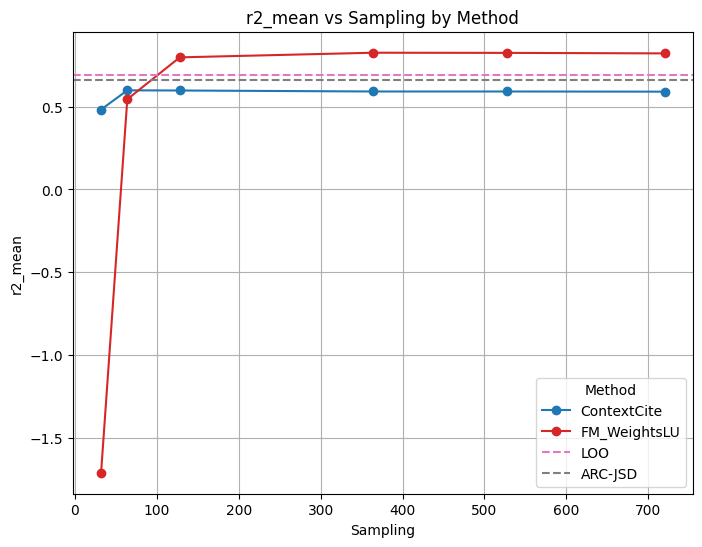

In [831]:
# df = df_r2_plot[df_r2_plot.method.isin(['ContextCite', 'FM_WeightsLU'])].copy()
df = df_plot[df_plot.method.isin(['ContextCite', 'FM_WeightsLU'])].copy()
# df = df_plot.copy()

# Extra methods with constant values
extra_methods = pd.DataFrame({
    "method": ["LOO", "ARC-JSD"],
    "r2_mean": [0.693, 0.658],
    "r2_std": [0.734, 0.168]
})

# Custom colors
colors = {
    'ContextCite': '#1f77b4',  
    'FBII': '#ff7f0e',        
    'Spex': '#2ca02c',        
    'FSII': '#8c564b',    
    'FM_WeightsDU': '#9467bd', 
    'FM_WeightsLU': '#d62728',  
    'LOO': '#e377c2',            
    'ARC-JSD': '#7f7f7f'         
}

# Pivot the table for normal methods
pivot_df = df.pivot(index="sampling", columns="method", values="r2_mean")

# Plot with custom colors
plt.figure(figsize=(8, 6))
for method in pivot_df.columns:
    plt.plot(
        pivot_df.index,
        pivot_df[method],
        marker="o",
        label=method,
        color=colors.get(method, "black")  # fallback = black
    )

# Add horizontal lines for LOO and ARC-JSD
for _, row in extra_methods.iterrows():
    plt.axhline(
        y=row["r2_mean"],
        linestyle="--",
        label=row["method"],
        color=colors.get(row["method"], "black")
    )

plt.xlabel("Sampling")
plt.ylabel("r2_mean")
plt.title("r2_mean vs Sampling by Method")
plt.legend(title="Method")
plt.grid(True)
plt.show()

#### Recall@k

In [677]:
def recall_at_k(gtset_k, inf_scores, k_val ):
    topk= np.array(inf_scores).argsort()[-k_val:]
    recall= len(set(gtset_k).intersection(topk))/len(gtset_k)
    return recall

In [684]:
k_values= [1,2,3,4,5]
recall_at_k_score_all = {}
support_index = 'supporting_documents_index' if level == 'document' else 'supporting_sentences_index'
for k_val in k_values:
    recall_at_k_score = {k:[] for k in eval(df_sample['method_scores'][0].replace('array', ''))[0].keys()}
    for i in df_sample.index:
        for method in list(recall_at_k_score.keys()): 
            provided_scoring = eval(df_sample.method_scores.loc[i].replace('array', ''))[0][method]
            # ground_truth_index= df_sample.loc[i].supporting_sentences_index
            ground_truth_index = df_sample[support_index].loc[i]
            recall_at_k_score[method].append(recall_at_k(ground_truth_index, provided_scoring, k_val=k_val))
    
    recall_at_k_score = {k:round(np.mean(v),4) for k,v in recall_at_k_score.items()}
    print(recall_at_k_score)
    recall_at_k_score_all[k_val] = recall_at_k_score
recall_res = pd.DataFrame.from_dict(recall_at_k_score_all, orient = 'index')

{'ContextCite528': np.float64(0.32), 'Spex528': np.float64(0.3289), 'FSII528': np.float64(0.3289), 'FM_WeightsLU528': np.float64(0.32), 'FM_WeightsDU528': np.float64(0.3289)}
{'ContextCite528': np.float64(0.6267), 'Spex528': np.float64(0.6178), 'FSII528': np.float64(0.5911), 'FM_WeightsLU528': np.float64(0.6267), 'FM_WeightsDU528': np.float64(0.64)}
{'ContextCite528': np.float64(0.9022), 'Spex528': np.float64(0.8844), 'FSII528': np.float64(0.8311), 'FM_WeightsLU528': np.float64(0.8978), 'FM_WeightsDU528': np.float64(0.9156)}
{'ContextCite528': np.float64(0.9422), 'Spex528': np.float64(0.9289), 'FSII528': np.float64(0.8844), 'FM_WeightsLU528': np.float64(0.9422), 'FM_WeightsDU528': np.float64(0.9644)}
{'ContextCite528': np.float64(0.9733), 'Spex528': np.float64(0.9422), 'FSII528': np.float64(0.9289), 'FM_WeightsLU528': np.float64(0.9778), 'FM_WeightsDU528': np.float64(0.9689)}


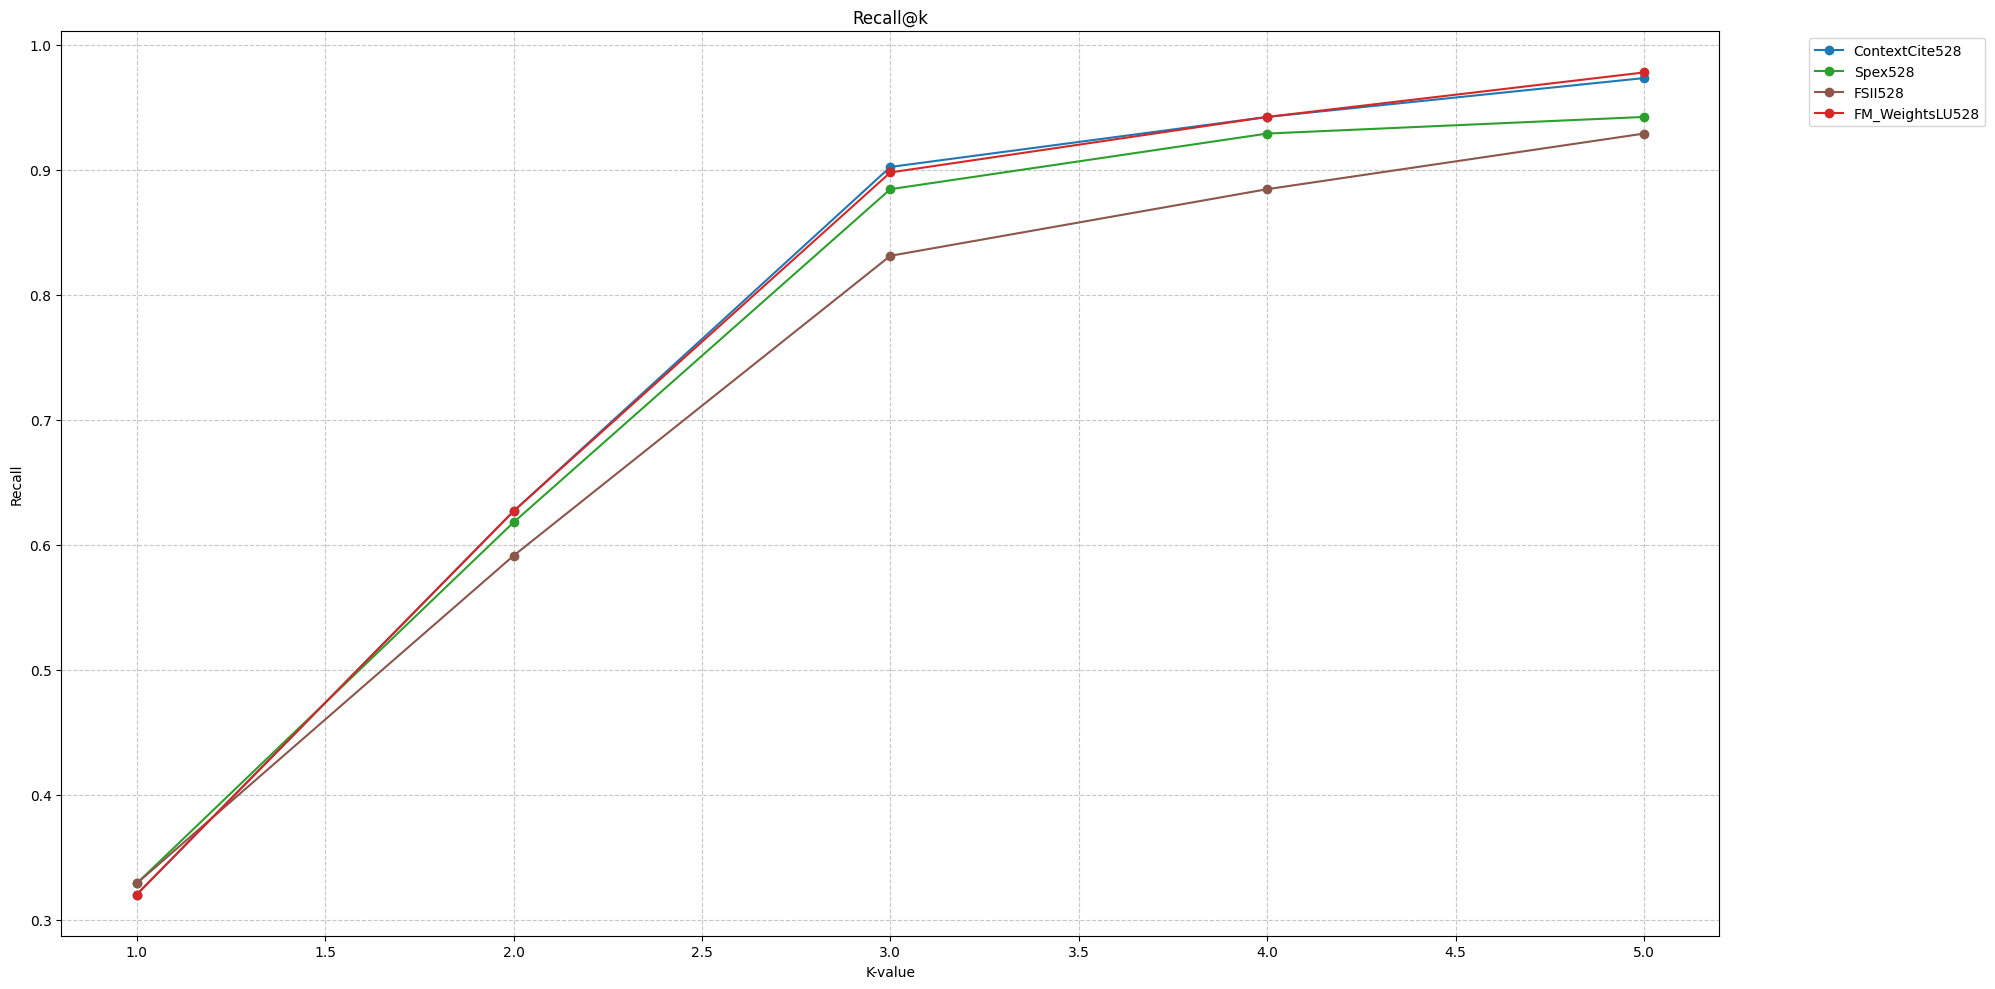

In [685]:
df = recall_res.copy()
plt.figure(figsize=(20,10))
sampling = ''.join([l for l in df.columns[0] if l.isdigit()])

colors = {
    f'ContextCite{sampling}': '#1f77b4',  
    f'FBII{sampling}': '#ff7f0e',        
    f'Spex{sampling}': '#2ca02c',        
    f'FSII{sampling}':   '#8c564b',    
    f'FM_WeightsDU{sampling}': '#9467bd', 
    f'FM_WeightsLU{sampling}': '#d62728',  
    'LOO': '#e377c2',            
    'ARC-JSD': '#7f7f7f'         
}

for col in df.columns: 
    if col != f'FM_WeightsDU{sampling}':
        plt.plot(df.index, df[col], label = col, color = colors[col], marker='o')

plt.xlabel('K-value')
plt.ylabel('Recall')
plt.title('Recall@k')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(True, linestyle='--', alpha = 0.7)

plt.tight_layout()
plt.show()


#### TopK-Prob/Div

In [877]:
metric = 'topk_probability'
topk_drop = {method :{k:[] for k in method_data.keys()} for method, method_data in eval(df_sample.topk_probability.loc[0])[0].items()}
methods = eval(df_sample.topk_probability.loc[0])[0].keys()
k_values = [1,2,3,4,5]
for i in df_sample.index: 
    for method in methods : 
        for k in k_values: 
            results = eval(df_sample[metric].loc[i])
            while len(results) == 1:
                results = results[0]
            topk_drop[method][k].append(results[method][k])

topk_drop = {method: {k:round(np.mean(v), 4) for k,v in method_data.items()} for method,method_data in topk_drop.items()}
df_res = pd.DataFrame.from_dict(topk_drop, orient = 'index').T

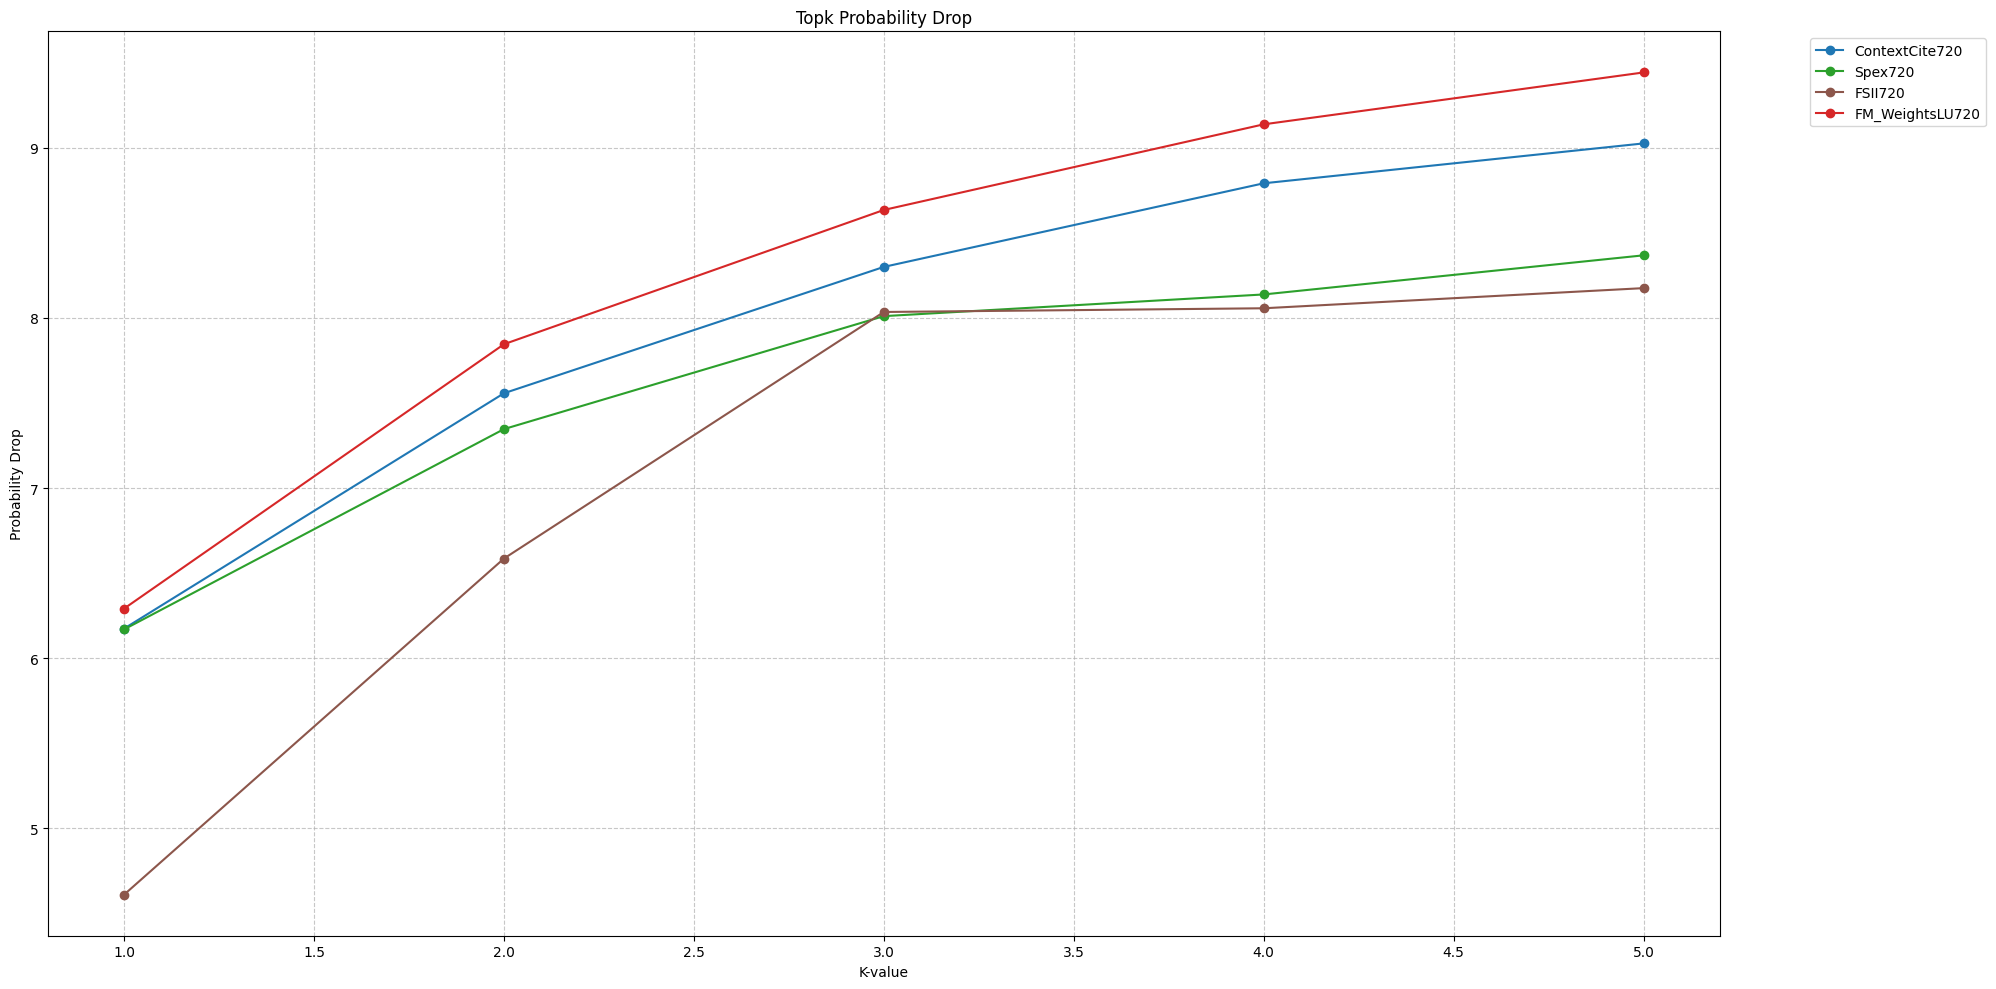

In [878]:
df = df_res.copy()
plt.figure(figsize=(20,10))
y_label = "Probability Drop" if metric == 'topk_probability' else "Divergence Climb"

sampling = ''.join([l for l in df.columns[0] if l.isdigit()])

colors = {
    f'ContextCite{sampling}': '#1f77b4',  
    f'FBII{sampling}': '#ff7f0e',        
    f'Spex{sampling}': '#2ca02c',        
    f'FSII{sampling}':   '#8c564b',    
    f'FM_WeightsDU{sampling}': '#9467bd', 
    f'FM_WeightsLU{sampling}': '#d62728',  
    'LOO': '#e377c2',            
    'ARC-JSD': '#7f7f7f'         
}

for col in df.columns: 
    if col != f'FM_WeightsDU{sampling}':
        plt.plot(df.index, df[col], label = col, marker='o', color = colors[col])

plt.xlabel('K-value')
plt.ylabel(y_label)
plt.title(f'Topk {y_label}')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(True, linestyle='--', alpha = 0.7)

plt.tight_layout()
plt.show()


### Sampling Level Aggregation

In [65]:
df = pd.read_csv('../Experiment_data/2wiki/Document/Vanilla/processed_results_sampling_32.csv')
df_agg = pd.DataFrame(columns = )
df

,question,context,provided_answer,lds_logit,lds_raw,rmse,r2,rmse_div,r2_div,topk_divergence,topk_probability,FMLU,FMDU,method_scores,answer,size_gt_doc,supporting_documents,flag_correct
0,What is the date of birth of Mina Gerhardsen's...,[[['Pamela Jain is an Indian playback singer. ...,13 June 1946.,[[[{'ContextCite32': np.float64(0.635826668992...,[[[{'ContextCite32': np.float64(0.743715239154...,"[[[{'ContextCite32': 29.334001128362434}, {'FM...","[[[{'ContextCite32': 0.4340901466896657}, {'FM...","[[[{'ContextCite32': 140.54738240120642}, {'FM...","[[[{'ContextCite32': -1031.3642432580302}, {'F...","[[{'ContextCite32': {1: 2.5490994974970818, 3:...","[[{'ContextCite32': {1: 16.1555021032691, 2: 1...","[[array([[ 0.00000000e+00, -2.34662320e+00, -1...","[[array([[ 0. , -0.04058917, 0.0385641...","[{'ContextCite32': array([ 0.46478554, 1.1631...",13 June 1946,2,['Mina Gerhardsen (born 14 September 1975) is ...,True
1,What nationality is the director of film Weddi...,"[[[""Weekend in Paradise( German: Wochenend im ...",Hungarian.,[[[{'ContextCite32': np.float64(0.903771281596...,[[[{'ContextCite32': np.float64(0.904338153503...,"[[[{'ContextCite32': 9.521712351394708}, {'FM_...","[[[{'ContextCite32': 0.6739564111409412}, {'FM...","[[[{'ContextCite32': 53.62154075660328}, {'FM_...","[[[{'ContextCite32': -1210.0561550738528}, {'F...","[{'ContextCite32': {1: 0.505605757352896, 3: 0...","[{'ContextCite32': {1: 3.652120530605316, 2: 7...","[[array([[ 0. , -0.44493117, -0.7084874...","[[array([[ 0. , -0.03366589, 0.0148607...","[{'ContextCite32': array([ 0.29869787, -0.5846...",Hungarian,2,"[""Wedding Night in Paradise is a 1950 West Ge...",True
2,When is the composer of film Sruthilayalu 's b...,[[['Bert Grund( 1920–1992) was a German compos...,Krishnankoil Venkadachalam Mahadevan's birthda...,[[[{'ContextCite32': np.float64(0.881110541196...,[[[{'ContextCite32': np.float64(0.816421916073...,"[[[{'ContextCite32': 0.17516575611757396}, {'F...","[[[{'ContextCite32': 0.9958930182261577}, {'FM...","[[[{'ContextCite32': 121.31669139198002}, {'FM...","[[[{'ContextCite32': -708.5054161061914}, {'FM...","[{'ContextCite32': {1: 7.56542189969332, 3: 9....","[{'ContextCite32': {1: 13.458739042282104, 2: ...","[[array([[ 0. , 1.03393094, -0.9820957...","[[array([[ 0. , 0.04794479, 0.0400677...","[{'ContextCite32': array([ 0.01763797, -0.2303...",14 March 1918,2,['Krishnankoil Venkadachalam Mahadevan (14 Mar...,True
3,Who is Rhescuporis I (Odrysian)'s paternal gra...,"[[['John Mackay( 1656–1754), known as( The Bli...",Cotys III.,[[[{'ContextCite32': np.float64(0.463610106024...,[[[{'ContextCite32': np.float64(0.462958843159...,"[[[{'ContextCite32': 18.531388570881745}, {'FM...","[[[{'ContextCite32': 0.056444199270497486}, {'...","[[[{'ContextCite32': 35.31477956028638}, {'FM_...","[[[{'ContextCite32': -541.3022394169709}, {'FM...","[{'ContextCite32': {1: 0.42675462633815187, 3:...","[{'ContextCite32': {1: 2.2481247186660767, 2: ...","[[array([[ 0. , 1.24699863, 5.1327751...","[[array([[ 0. , 0.00378841, 0.0025487...","[{'ContextCite32': array([-3.25973031, 0.7545...",Raizdos,2,['Rhescuporis I (Ancient Greek: Ραισκούπορις) ...,False
4,Where was the director of film The Fascist born?,[[['Olav Aaraas( born 10 July 1950) is a Norwe...,Rome.,[[[{'ContextCite32': np.float64(0.914031747134...,[[[{'ContextCite32': np.float64(0.915906562847...,"[[[{'ContextCite32': 2.246954710345422}, {'FM_...","[[[{'ContextCite32': 0.9512515517404555}, {'FM...","[[[{'ContextCite32': 74.44575939909099}, {'FM_...","[[[{'ContextCite32': -746.5609759685245}, {'FM...","[{'ContextCite32': {1: 1.0095405988395214, 3: ...","[{'ContextCite32': {1: 10.67279839515686, 2: 1...","[[array([[ 0. , -2.28748999, -3.3912535...","[[array([[ 0. , -0.0222639 , -0.0091993...","[{'ContextCite32': array([ 0.47307094, 0.6371...",Rome,2,['The Fascist is a 1961 Italian film directed...,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Where was the father of Mar